Notebook used for initial analysis of the scraped WSJ articles.

In [1]:
import pandas as pd
import numpy as np
import os
import sqlite3
import re
import seaborn as sns   
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import sys
from pathlib import Path

# connect to directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
annotation_dir = os.path.join(parent_dir,"src","annotation")
flag_dir = os.path.join(parent_dir,"src","preprocessing")

if annotation_dir not in sys.path:
    sys.path.append(annotation_dir)

if flag_dir not in sys.path:
    sys.path.append(flag_dir)


# import the mentions ai function
from simple_ai_filter import flag_ai_mentions



In [2]:
# connect to subdirectory
db_path = os.path.join(parent_dir, "data", "processed", "articles","articlesWSJ_clean_2024.db")

# Connect to the database
conn = sqlite3.connect(db_path)

# explore table names
query = "SELECT name FROM sqlite_master WHERE type='table';"
table_names = pd.read_sql_query(query, conn)
print("Table names in the database:")
print(table_names)

df = pd.read_sql_query("SELECT * FROM article", conn)
conn.close()

Table names in the database:
             name
0         article
1  articles_index


In [3]:
# perform initial analysis
print("Number of rows in the DataFrame:", len(df))
print("Number of columns in the DataFrame:", len(df.columns))   
print("Columns in the DataFrame:", df.columns.tolist())

Number of rows in the DataFrame: 14443
Number of columns in the DataFrame: 12
Columns in the DataFrame: ['article_id', 'image_src', 'scanned_time', 'title', 'sub_title', 'corpus', 'index_id', 'id', 'date', 'link', 'section', 'cleaned_corpus']


Flag articles which contain "AI, A.I., artificial intelligence, machine learning, deep learning, LLM, GPT, ChatGPT, OpenAI, transformer model or generative AI" (case-insensitive and uses word boundaries).  

In [4]:
# check for AI-related articles using importflag_ai_mentions from mentions_ai.py
df_labeled = flag_ai_mentions(df)

1821 out of 14443 articles mention AI-related topics.


Analyze distribution by section and evolution over time

In [6]:
# fractioin of AI-related articles
print("Fraction of AI-related articles:", df_labeled["mentions_ai"].sum() / len(df_labeled))

# sections in the dataset
sections = df_labeled["section"].unique()
print("Sections in the dataset:", sections)

# create list of count for each section
section_counts = df_labeled["section"].value_counts()
print("Counts of articles in each section:", section_counts)

# crea a list of counts for each section by ai_relatedness
section_ai_counts = df_labeled.groupby(["section", "mentions_ai"]).size().unstack(fill_value=0)  
print("Counts of articles in each section by AI-relatedness:", section_ai_counts)


Fraction of AI-related articles: 0.12608183895312608
Sections in the dataset: ['business' 'opinion' 'world' 'us-news' 'tech' 'finance' 'economy'
 'politics']
Counts of articles in each section: section
opinion     4854
business    2914
world       1765
finance     1588
politics    1126
us-news      769
tech         731
economy      696
Name: count, dtype: int64
Counts of articles in each section by AI-relatedness: mentions_ai  False  True 
section                  
business      2409    505
economy        644     52
finance       1294    294
opinion       4597    257
politics      1048     78
tech           238    493
us-news        741     28
world         1651    114


In [7]:
# normalize the daily counts by total counts of the given day
daily_counts_grouped = df_labeled.groupby(["date", "mentions_ai"]).size().unstack(fill_value=0).reset_index()
daily_counts_grouped["frac_ai"] = daily_counts_grouped[1] / (daily_counts_grouped[0] + daily_counts_grouped[1]) 
# 
print(daily_counts_grouped.head())

mentions_ai                 date  False  True   frac_ai
0            2024-01-01 00:00:00     34     5  0.128205
1            2024-01-02 00:00:00     71     4  0.053333
2            2024-01-03 00:00:00     43     4  0.085106
3            2024-01-04 00:00:00     54     6  0.100000
4            2024-01-05 00:00:00     53     3  0.053571


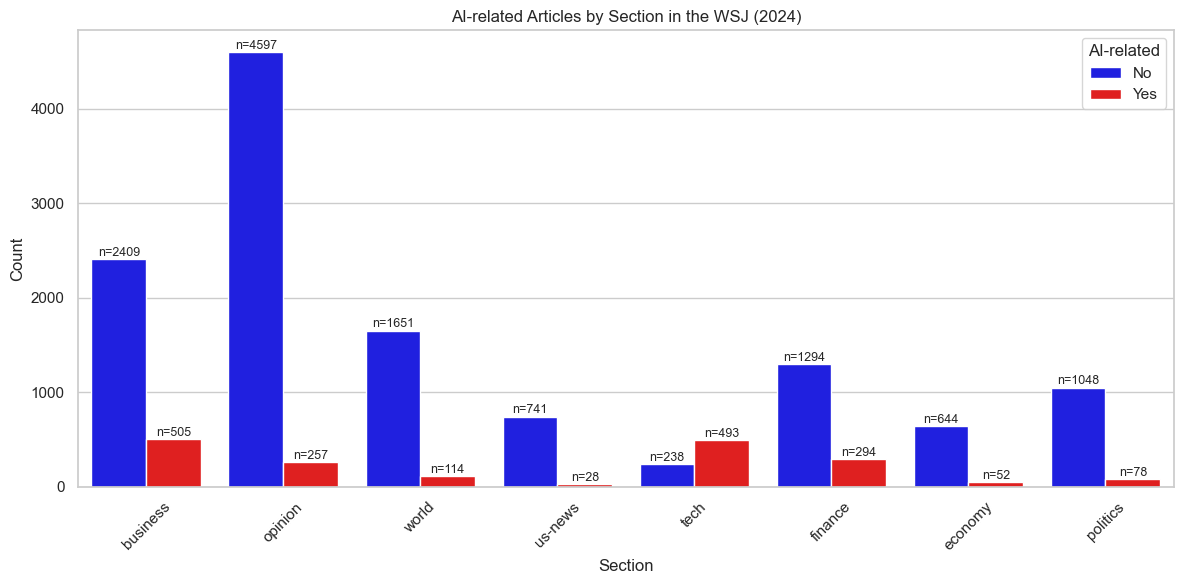

In [10]:
# v isualize the data using seaborn
# Set the style of seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6)) 

# Create the countplot
ax = sns.countplot(data=df_labeled, x="section", hue="mentions_ai", palette=["blue", "red"])

# Add bar labels
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(
            p.get_x() + p.get_width() / 2.,  # x-position
            height + 1,                     # y-position 
            f'n={int(height)}',             # text label
            ha="center", va="bottom", fontsize=9
        )

# Final plot formatting
plt.title("AI-related Articles by Section in the WSJ (2024)")
plt.xlabel("Section")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="AI-related", loc="upper right", labels=["No", "Yes"])
plt.tight_layout()
fig_path = os.path.join(parent_dir,"reports","figures","WSJ2024_AIrel_articles_by_section.png")
plt.savefig(fig_path, dpi=300)
plt.show()


Next, the number of articles per day is analyzed

In [11]:
# group by day and count#
df_labeled['date'] = pd.to_datetime(df_labeled['date'])
daily_counts = df_labeled.groupby(df_labeled['date'].dt.date).size().reset_index(name='count')

# Show all rows in notebook or script
pd.set_option('display.max_rows', None)

# Filter and display
display(daily_counts[daily_counts['count'] < 25])

,date,count
5,2024-01-06,21
12,2024-01-13,23
13,2024-01-14,22
33,2024-02-03,20
40,2024-02-10,21
47,2024-02-17,19
48,2024-02-18,20
50,2024-02-20,24
51,2024-02-21,22
54,2024-02-24,16


Investigation is performed over all years (2023-2025)

In [ ]:
parent_dir

'c:\\Users\\PC\\Desktop\\Masterarbeit\\AI_narrative_index'

In [15]:
# define root
parent_dir = Path(__file__).resolve().parent.parent if "__file__" in globals() else Path.cwd().parent

# build file paths for all years dynamically
data_dir = parent_dir / "data" / "processed" / "variables"
files = [
    data_dir / f"FinBERT_AINI_prediction_{year}_windsize_1.csv"
    for year in (2023, 2024, 2025)
]

# load and concatenate
df_total = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

print(df_total.shape)
df_total.head()

(22904, 18)


,article_id,image_src,scanned_time,title,sub_title,corpus,index_id,id,date,link,section,cleaned_corpus,text,ai_window,ai_relevant,sentiment_label,sentiment_score,hype_score
0,202336,NaN,2025-05-15 16:24:51,Best Buy-Owned Phone Service Faces Angry Custo...,Some Jitterbug phone users have been unable to...,Advertisement\nBUSINESS\nTELECOM\nBest Buy-Own...,154,154,2023-01-10,https://www.wsj.com/business/telecom/best-buy-...,business,Best. Buy-Owned. Phone. Service. Faces. Angry....,Best Buy-Owned Phone Service Faces Angry Custo...,NaN,False,neutral,0.0,0
1,202339,NaN,2025-05-15 16:32:16,Biden Administration Plans to Ease Rules for I...,Proposed plan would allow low earners to pay l...,Advertisement\nPOLITICS\nPOLICY\nBiden Adminis...,157,157,2023-01-10,https://www.wsj.com/politics/policy/biden-admi...,politics,Biden. Administration. Plans to. Ease. Rules f...,Biden Administration Plans to Ease Rules for I...,NaN,False,neutral,0.0,0
2,202387,NaN,2025-05-15 16:43:13,Garland Names Robert Hur Special Counsel to In...,Appointment comes after classified documents w...,Advertisement\nPOLITICS\nNATIONAL SECURITY\nGa...,186,186,2023-01-12,https://www.wsj.com/politics/national-security...,politics,Appointment comes after classified documents w...,Garland Names Robert Hur Special Counsel to In...,NaN,False,neutral,0.0,0
3,2023102,NaN,2025-05-15 16:46:49,Amazon Appeal to Union Victory in New York Rej...,Company says union used inappropriate methods ...,Advertisement\nBUSINESS\nRETAIL\nAmazon Appeal...,201,201,2023-01-12,https://www.wsj.com/business/retail/amazon-app...,business,4 min. Workers from. Amazon's. Staten. Island ...,Amazon Appeal to Union Victory in New York Rej...,NaN,False,neutral,0.0,0
4,2023111,NaN,2025-05-15 16:48:53,Before Biden Left the White House as Vice Pres...,Discovery of classified documents puts scrutin...,Before Biden Left the White House as Vice Pres...,204,204,2023-01-13,https://www.wsj.com/politics/national-security...,politics,Before. Biden. Left the. White. House as. Vice...,Before Biden Left the White House as Vice Pres...,NaN,False,neutral,0.0,0


In [16]:
# explore descriptives
print(set(df_total.section))

# drop prior 01/04/23
df_total["date"] = pd.to_datetime(df_total["date"])
df_total = df_total[df_total["date"] > pd.to_datetime("2023-03-31")]

# count total articles
df_total.groupby(df_total["date"].dt.year)["date"].count()



{'tech', 'opinion', 'finance', 'politics', 'economy', 'us-news', 'business', 'world'}


date
2023     4075
2024    14443
2025     4060
Name: date, dtype: int64

In [17]:
# print total number
print(df_total.shape[0])

22578
